In [2]:
!pip install -q gwpy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# !pip install rouge_score
# !pip install py7zr
# !pip install transformers
# !pip install datasets
# !pip install rouge
from typing import List
import os
import json
import ast
import pandas as pd
import csv
import argparse
import pickle
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, load_from_disk
import numpy as np
from datasets import load_dataset, load_metric, load_from_disk
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rouge import Rouge
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read csv files

In [4]:
curr_path = os.getcwd()

# Path to twcs.csv File
twcs = pd.read_csv(curr_path + '/drive/MyDrive/twcs.csv')

In [6]:
twcs.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


### Creating a dictionary for tweet Data


In [ ]:
twcs_dict = {}
for i in range(len(twcs)):
    twcs_dict[twcs.iloc[i]['tweet_id']] = [twcs.iloc[i]['author_id'], twcs.iloc[i]['text']]    

### Store the twcs dictionary variable (Optional)
Store twcs_dict variable if you need since it takes a long time to rerun the code.

In [ ]:
# Store the dictionary variable 
f_twcs_dict = open('twcs_dict.pckl', 'wb')
pickle.dump(twcs_dict, f_twcs_dict)
f_twcs_dict.close()

In [5]:
# Get twcs_dict data from the following link if you need it 
# https://drive.google.com/file/d/1uX5vS3n5eICIZjvJLSusue8Euw7JuXSM/view?usp=share_link
f_twcs_dict = open(curr_path + '/drive/MyDrive/twcs_dict.pckl', 'rb')
twcs_dict = pickle.load(f_twcs_dict)

## Get dialogs with summaries

In [6]:
def get_dialog_with_summaries(TWEETSUM_JSON_FILE_PATH):
  with open(TWEETSUM_JSON_FILE_PATH, 'r') as json_file:
    test_data = [json.loads(line) for line in json_file]

  parsed = []
  for t in test_data:    
      anno = t['annotations']    
      for a in anno:      
          abst = a['abstractive']
          tweets = a['extractive']
          if tweets is not None:
              dialog = []
              for t in tweets:                    
                  dialog.append(twcs_dict[t['tweet_id']][0] + ": " + twcs_dict[t['tweet_id']][1] + "\n")    
              if (abst is not None):
                parsed.append(["".join(dialog), " ".join(abst)])              

  return parsed

TWEETSUM_JSON_FILE_TRAIN_PATH = curr_path + "/final_train_tweetsum.jsonl"
TWEETSUM_JSON_FILE_VALID_PATH = curr_path + "/final_valid_tweetsum.jsonl"
TWEETSUM_JSON_FILE_TEST_PATH = curr_path + "/final_test_tweetsum.jsonl"

TRAIN_DATA_parsed = get_dialog_with_summaries(TWEETSUM_JSON_FILE_TRAIN_PATH)
VALID_DATA_parsed = get_dialog_with_summaries(TWEETSUM_JSON_FILE_VALID_PATH)
TEST_DATA_parsed = get_dialog_with_summaries(TWEETSUM_JSON_FILE_TEST_PATH)

In [7]:
train_parsed = pd.DataFrame(TRAIN_DATA_parsed, columns=['dialog', 'summary'])
valid_parsed =  pd.DataFrame(VALID_DATA_parsed, columns=['dialog', 'summary'])
test_parsed = pd.DataFrame(TEST_DATA_parsed, columns=['dialog', 'summary'])

In [8]:
print("Total Training data: ", len(train_parsed))
print("Total Valid data   : ", len(valid_parsed))
print("Total Testing data : ", len(test_parsed))

Total Training data:  2406
Total Valid data   :  327
Total Testing data :  311


In [60]:
train_parsed.head(5)

,dialog,summary
0,135060: So neither my iPhone nor my Apple Watc...,Customer enquired about his Iphone and Apple w...
1,135060: So neither my iPhone nor my Apple Watc...,The customer has a problem. The agent in a ver...
2,135060: So neither my iPhone nor my Apple Watc...,Health and activity functions are not working ...
3,264322: @115850 hi team! i m planning to get A...,Customer is eager to know about the replacemen...
4,264322: @115850 hi team! i m planning to get A...,Wants to know about the 10 day return policy f...


In [61]:
valid_parsed.head(5)

,dialog,summary
0,"160485: @SpotifyCares hey, any explanation why...",Customer is complaining about unable to create...
1,"160485: @SpotifyCares hey, any explanation why...",Customer asking explanation why the create si...
2,"160485: @SpotifyCares hey, any explanation why...",Customer is complaining that he is unable to c...
3,310046: @GWRHelp 1st class WiFi is slower then...,Customer is complaining about the slow wifi co...
4,310046: @GWRHelp 1st class WiFi is slower then...,Customer is complaining about the 1st class WI...


In [62]:
test_parsed.head(3)

,dialog,summary
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...
1,658975: @hulu_support My watchlist is not upda...,Customer is complaining that my watch list is ...
2,658975: @hulu_support My watchlist is not upda...,Customer is complaining that he is not getting...


In [ ]:
test_parsed.to_csv('./twcs_test.csv')

In [ ]:
test_parsed.to_csv('./twcs_test.csv')

### Creating a summarization with bart-large-samsum

In [ ]:
def run_summarizer(input, model_name):
    output_list = []
    
    summarizer = pipeline("summarization", model=model_name)

    for i in range(len(input)):
        output_list.append(summarizer(input[i]))
    
    return output_list

In [ ]:
model_name="linydub/bart-large-samsum"
test_result = run_summarizer(test_parsed['dialog'].tolist(), model_name)

test_parsed['predicted'] = test_result

test_parsed.to_csv('./twcs_test_predicted.csv')

Your max_length is set to 62, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 62, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 62, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 62, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 62, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


In [ ]:
# Store the test_result variable
test_result_obj = open('test_parsed.pckl', 'wb')
pickle.dump(test_result, test_result_obj)
f_twcs_dict.close()

In [ ]:
# test_result_obj = open(curr_path + '/drive/MyDrive/test_parsed.pckl', 'rb')
# test_result_copy = pickle.load(test_result_obj)
# test_parsed['predicted'] = test_result_copy

### Showing the Predicted result

In [ ]:
test_parsed.head(5)

,dialog,summary,predicted
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...,[{'summary_text': 'Norlene's watchlist is not ...
1,658975: @hulu_support My watchlist is not upda...,Customer is complaining that my watch list is ...,[{'summary_text': 'Hulu's watchlist is not upd...
2,658975: @hulu_support My watchlist is not upda...,Customer is complaining that he is not getting...,[{'summary_text': 'Norlene's Hulu watchlist is...
3,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is asking about the ACC to link to th...,[{'summary_text': '637109's Acc was linked to ...
4,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is enquiring that whether they can ch...,[{'summary_text': 'Airbnb help asks 637109 to ...


### Compare Two Summarizations with Cosine Similarity


In [ ]:
# Reference https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
def generation_cosine_similarity(X, Y):  
  # tokenization
  X_list = word_tokenize(X) 
  Y_list = word_tokenize(Y)
    
  # sw contains the list of stopwords
  sw = stopwords.words('english') 
  l1 =[];l2 =[]
    
  # remove stop words from the string
  X_set = {w for w in X_list if not w in sw} 
  Y_set = {w for w in Y_list if not w in sw}
    
  # form a set containing keywords of both strings 
  rvector = X_set.union(Y_set) 
  for w in rvector:
      if w in X_set: l1.append(1) # create a vector
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
  c = 0
    
  # cosine formula 
  for i in range(len(rvector)):
          c+= l1[i]*l2[i]
  cosine = c / float((sum(l1)*sum(l2))**0.5)
  return cosine
consine_similarity_scores = []

for i in range(len(test_parsed)):
  X = test_parsed['summary'][i]
  Y = test_parsed['predicted'][i][0]['summary_text']
  cosine_sim = generation_cosine_similarity(X,Y)
  consine_similarity_scores.append(cosine_sim)


In [ ]:
test_parsed['cosine_similarities'] = consine_similarity_scores

In [ ]:
test_parsed.head(5)

,dialog,summary,predicted,cosine_similarities
0,658975: @hulu_support My watchlist is not upda...,Customer is complaining that the watchlist is ...,[{'summary_text': 'Norlene's watchlist is not ...,0.372678
1,658975: @hulu_support My watchlist is not upda...,Customer is complaining that my watch list is ...,[{'summary_text': 'Hulu's watchlist is not upd...,0.416025
2,658975: @hulu_support My watchlist is not upda...,Customer is complaining that he is not getting...,[{'summary_text': 'Norlene's Hulu watchlist is...,0.282843
3,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is asking about the ACC to link to th...,[{'summary_text': '637109's Acc was linked to ...,0.246183
4,"637109: @AirbnbHelp hi , my Acc was linked to ...",Customer is enquiring that whether they can ch...,[{'summary_text': 'Airbnb help asks 637109 to ...,0.072739


In [ ]:
print("Max for cosine_similarities    : ", np.max(test_parsed['cosine_similarities']))
print("Min for cosine_similarities    : ", np.min(test_parsed['cosine_similarities']))
print("Mean for cosine_similarities   : ", np.mean(test_parsed['cosine_similarities']))
print("Median for cosine_similarities : ", np.median(test_parsed['cosine_similarities']))

Max for cosine_similarities    :  0.7735267838285931
Min for cosine_similarities    :  0.051639777949432225
Mean for cosine_similarities   :  0.29148590319586826
Median for cosine_similarities :  0.27386127875258304


<AxesSubplot:title={'center':'Cosine Similarities for two summarizations'}, xlabel='cosine_similarities'>

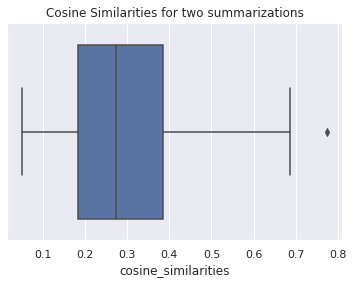

In [ ]:
sns.set(style="darkgrid")
plt.title("Cosine Similarities for two summarizations")
sns.boxplot(x=test_parsed["cosine_similarities"])

## Compare Two summarizations with Rouge 1, 2

#### Calculate Rouge-1 and Rouge-2 by avg

In [ ]:
predicted_summaries = []
for i in test_parsed['predicted']:
  predicted_summaries.append(i[0]['summary_text'])

summaries = list(test_parsed['summary'])

rouge = Rouge()
rouge.get_scores(predicted_summaries, summaries, avg=True)

{'rouge-1': {'r': 0.24570896368189374,
  'p': 0.35079820042920035,
  'f': 0.2798223221854206},
 'rouge-2': {'r': 0.0884557780530421,
  'p': 0.14546800689778758,
  'f': 0.10564611568567775},
 'rouge-l': {'r': 0.22787529894316164,
  'p': 0.3249177184493534,
  'f': 0.2593398966192099}}

### Draw boxplots for Rouge 1 and 2 

In [ ]:
def generation_Rouge_Scores(X, Y):  
  rouge = Rouge()
  return rouge.get_scores(X, Y)

In [ ]:
def get_rouge1_rouge2_scores_for_bxplot(test_parsed):
  Rouge_1_f1scores_list = []
  Rouge_2_f1scores_list = []
  Rouge_1_precision_list = []
  Rouge_2_precision_list = []
  Rouge_1_recall_list = []
  Rouge_2_recall_list = []
  for i in range(len(test_parsed)):
    X = test_parsed['summary'][i]
    Y = test_parsed['predicted'][i][0]['summary_text']  
    get_rouge_scores = generation_Rouge_Scores(X,Y)
    Rouge_1_f1scores = get_rouge_scores[0]['rouge-1']['f']
    Rouge_2_f1scores = get_rouge_scores[0]['rouge-2']['f']

    Rouge_1_f1scores_list.append(Rouge_1_f1scores)
    Rouge_2_f1scores_list.append(Rouge_2_f1scores)

    Rouge_1_precision = get_rouge_scores[0]['rouge-1']['p']
    Rouge_2_precision = get_rouge_scores[0]['rouge-2']['p']

    Rouge_1_precision_list.append(Rouge_1_precision)
    Rouge_2_precision_list.append(Rouge_2_precision)

    Rouge_1_recall = get_rouge_scores[0]['rouge-1']['r']
    Rouge_2_recall = get_rouge_scores[0]['rouge-2']['r']

    Rouge_1_recall_list.append(Rouge_1_recall)
    Rouge_2_recall_list.append(Rouge_2_recall)
  return Rouge_1_f1scores_list, Rouge_2_f1scores_list

In [ ]:
Rouge_1_f1scores_list = []
Rouge_2_f1scores_list = []
Rouge_1_f1scores_list, Rouge_2_f1scores_list = get_rouge1_rouge2_scores_for_bxplot(test_parsed)

In [ ]:
test_parsed['Rouge_1_f1scores'] = Rouge_1_f1scores_list
test_parsed['Rouge_2_f1scores'] = Rouge_2_f1scores_list

In [ ]:
print("Max for Rouge_1 f1 scores    : ", np.max(test_parsed['Rouge_1_f1scores']))
print("Min for Rouge_1 f1 scores    : ", np.min(test_parsed['Rouge_1_f1scores']))
print("Mean for Rouge_1 f1 scores   : ", np.mean(test_parsed['Rouge_1_f1scores']))
print("Median for Rouge_1 f1 scores : ", np.median(test_parsed['Rouge_1_f1scores']))

Max for Rouge_1 f1 scores    :  0.7692307642833663
Min for Rouge_1 f1 scores    :  0.0
Mean for Rouge_1 f1 scores   :  0.2798223221854205
Median for Rouge_1 f1 scores :  0.272727267820248


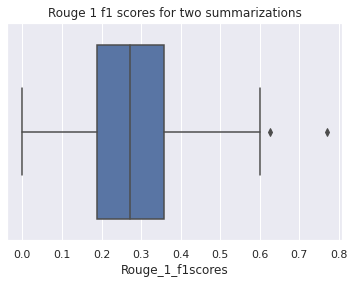

In [ ]:
sns.set(style="darkgrid")
plt.title("Rouge 1 f1 scores for two summarizations")
sns.boxplot(x=test_parsed["Rouge_1_f1scores"])

In [ ]:
print("Max for Rouge_2 f1 scores    : ", np.max(test_parsed['Rouge_2_f1scores']))
print("Min for Rouge_2 f1 scores    : ", np.min(test_parsed['Rouge_2_f1scores']))
print("Mean for Rouge_2 f1 scores   : ", np.mean(test_parsed['Rouge_2_f1scores']))
print("Median for Rouge_2 f1 scores : ", np.median(test_parsed['Rouge_2_f1scores']))

Max for Rouge_2 f1 scores    :  0.5777777728987655
Min for Rouge_2 f1 scores    :  0.0
Mean for Rouge_2 f1 scores   :  0.10564611568567779
Median for Rouge_2 f1 scores :  0.07547169351370622


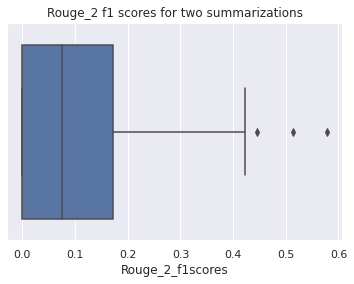

In [ ]:
plt.title("Rouge_2 f1 scores for two summarizations")
sns.boxplot(x=test_parsed["Rouge_2_f1scores"])

### Creating a summarization with distilbart-cnn-12-6-samsum

In [ ]:
model_name="philschmid/distilbart-cnn-12-6-samsum"
test_result = run_summarizer(test_parsed['dialog'].tolist(), model_name)

In [ ]:
test_parsed['predicted'] = test_result

test_parsed.to_csv('./twcs_test_predicted.csv')

## Compare Two summarizations with Rouge 1, 2 (cnn-12-6-samsum model)


In [ ]:
predicted_summaries = []
for i in test_parsed['predicted']:
  predicted_summaries.append(i[0]['summary_text'])

summaries = list(test_parsed['summary'])

rouge = Rouge()
rouge.get_scores(predicted_summaries, summaries, avg=True)

{'rouge-1': {'r': 0.3765433369468683,
  'p': 0.30912337514497185,
  'f': 0.33293488751971356},
 'rouge-2': {'r': 0.1476315209507142,
  'p': 0.12496764359410285,
  'f': 0.13145719812026307},
 'rouge-l': {'r': 0.34711125404543186,
  'p': 0.2844990331217645,
  'f': 0.30650491207974473}}

In [ ]:
Rouge_1_f1scores_CNN = []
Rouge_2_f1scores_CNN = []
Rouge_1_f1scores_CNN, Rouge_2_f1scores_CNN = get_rouge1_rouge2_scores_for_bxplot(test_parsed)

In [ ]:
print("Max for Rouge_1 f1 scores    : ", np.max(Rouge_1_f1scores_CNN))
print("Min for Rouge_1 f1 scores    : ", np.min(Rouge_1_f1scores_CNN))
print("Mean for Rouge_1 f1 scores   : ", np.mean(Rouge_1_f1scores_CNN))
print("Median for Rouge_1 f1 scores : ", np.median(Rouge_1_f1scores_CNN))

Max for Rouge_1 f1 scores    :  0.6842105214854571
Min for Rouge_1 f1 scores    :  0.04347825681474518
Mean for Rouge_1 f1 scores   :  0.3329348875197135
Median for Rouge_1 f1 scores :  0.3278688475678581


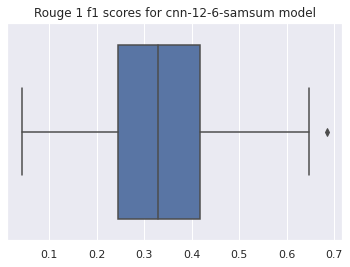

In [ ]:
sns.set(style="darkgrid")
plt.title("Rouge 1 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_1_f1scores_CNN)

In [ ]:
print("Max for Rouge_2 f1 scores    : ", np.max(Rouge_2_f1scores_CNN))
print("Min for Rouge_2 f1 scores    : ", np.min(Rouge_2_f1scores_CNN))
print("Mean for Rouge_2 f1 scores   : ", np.mean(Rouge_2_f1scores_CNN))
print("Median for Rouge_2 f1 scores : ", np.median(Rouge_2_f1scores_CNN))

Max for Rouge_2 f1 scores    :  0.5352112627256498
Min for Rouge_2 f1 scores    :  0.0
Mean for Rouge_2 f1 scores   :  0.1314571981202631
Median for Rouge_2 f1 scores :  0.10810810310810835


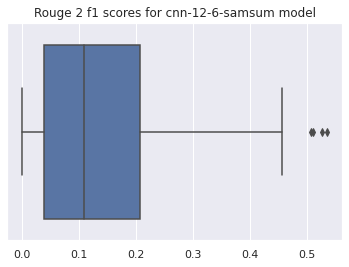

In [ ]:
sns.set(style="darkgrid")
plt.title("Rouge 2 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_2_f1scores_CNN)

### Finetuning CNN-12-6-samsum

In [10]:
max_input = 512
max_target = 128
batch_size = 3
model_name= "philschmid/distilbart-cnn-12-6-samsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [11]:
def preprocess_data(data_to_process):
  #get all the dialogues  
  data_to_process['dialog'] = data_to_process['dialog'].astype('string')
  data_to_process['summary'] = data_to_process['summary'].astype('string')
  list_summary = list(data_to_process['summary'])
  inputs = [dialogue for dialogue in data_to_process['dialog']]
  #tokenize the dialogues
  model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(list_summary, max_length=max_target, padding='max_length', truncation=True)
  #set labels
  'id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'
  model_inputs['labels'] = targets['input_ids']

  #return the tokenized data
  #input_ids, attention_mask and labels
  results = []
  for i in range (len(list(data_to_process['dialog']))):
    dic = {'dialogue':list(data_to_process['dialog'])[i], 'summary':list(data_to_process['summary'])[i],'input_ids':model_inputs['input_ids'][i], 'attention_mask':model_inputs['attention_mask'][i], 'labels':model_inputs['labels'][i]}
    results.append(dic)
  return results



In [12]:
preprocessed_train_data = preprocess_data(train_parsed)
preprocessed_valid_data = preprocess_data(valid_parsed)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [13]:
model_name="philschmid/distilbart-cnn-12-6-samsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
metric = load_metric('rouge')
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)
def compute_rouge(pred):
  predictions, labels = pred
  #decode the predictions
  decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #compute results
  res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
  #get %
  res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

  pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  res['gen_len'] = np.mean(pred_lens)

  return {k: round(v, 4) for k, v in res.items()}

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
args = Seq2SeqTrainingArguments(
    'conversation-summ', #save directory
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size= 2,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=preprocessed_train_data,
    eval_dataset=preprocessed_valid_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

Using cuda_amp half precision backend


In [15]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2406
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 2
  Total optimization steps = 1803
  Number of trainable parameters = 305510400
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is fas

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,0.993700,0.553394,48.732700,26.400500,40.263800,40.257600,64.006100
1,0.518900,0.536219,48.060300,25.584400,39.338000,39.333100,63.489300
2,0.440200,0.543645,48.406700,25.800900,39.594000,39.581300,63.874600


Saving model checkpoint to conversation-summ/checkpoint-500
Configuration saved in conversation-summ/checkpoint-500/config.json
Model weights saved in conversation-summ/checkpoint-500/pytorch_model.bin
tokenizer config file saved in conversation-summ/checkpoint-500/tokenizer_config.json
Special tokens file saved in conversation-summ/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 327
  Batch size = 2
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, dialogue. If summary, dialogue are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
Saving model checkpoint to conversation-summ/checkpoint-1000
Configuration saved in conversation-summ/checkpoint-1000/config.json
Model weights saved in conversation-summ/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in conversation-summ/checkpoint-1000/token

TrainOutput(global_step=1803, training_loss=0.6107664399191993, metrics={'train_runtime': 1390.5597, 'train_samples_per_second': 5.191, 'train_steps_per_second': 1.297, 'total_flos': 5584866804498432.0, 'train_loss': 0.6107664399191993, 'epoch': 3.0})

In [49]:
predicted_sum = []
for test_dialog in test_parsed['dialog']:
  model_inputs = tokenizer(test_dialog,  max_length=max_input, padding='max_length', truncation=True)
  raw_pred, _, _ = trainer.predict([model_inputs])
  predicted_sum.append(tokenizer.decode(raw_pred[0]))

In [34]:
cleaned_data = []
for summary in predicted_sum:
  summary= summary.replace('</s>', '')
  summary= summary.replace('<s>', '')
  summary= summary.replace('<pad>', '')
  cleaned_data.append(summary)

In [37]:
test_parsed['finetuned_predicted'] = cleaned_data

In [44]:
summaries = list(test_parsed['summary'])

rouge = Rouge()
rouge.get_scores(list(test_parsed['finetuned_predicted']), summaries, avg=True)

{'rouge-1': {'r': 0.5643947436221978,
  'p': 0.39018264480105086,
  'f': 0.45286780606888233},
 'rouge-2': {'r': 0.2736749307417887,
  'p': 0.1793288329245975,
  'f': 0.21075460668899765},
 'rouge-l': {'r': 0.5211788376632477,
  'p': 0.3600503078605399,
  'f': 0.41792136834257676}}

In [46]:
test_parsed.to_csv("predicted_with_finetuned_model.csv")

In [50]:
def generation_Rouge_Scores(X, Y):  
  rouge = Rouge()
  return rouge.get_scores(X, Y)

def get_rouge1_rouge2_scores_for_bxplot(test_parsed):
  Rouge_1_f1scores_list = []
  Rouge_2_f1scores_list = []
  Rouge_1_precision_list = []
  Rouge_2_precision_list = []
  Rouge_1_recall_list = []
  Rouge_2_recall_list = []
  for i in range(len(test_parsed)):
    X = test_parsed['summary'][i]
    Y = test_parsed['finetuned_predicted'][i]
    get_rouge_scores = generation_Rouge_Scores(X,Y)
    Rouge_1_f1scores = get_rouge_scores[0]['rouge-1']['f']
    Rouge_2_f1scores = get_rouge_scores[0]['rouge-2']['f']

    Rouge_1_f1scores_list.append(Rouge_1_f1scores)
    Rouge_2_f1scores_list.append(Rouge_2_f1scores)

    Rouge_1_precision = get_rouge_scores[0]['rouge-1']['p']
    Rouge_2_precision = get_rouge_scores[0]['rouge-2']['p']

    Rouge_1_precision_list.append(Rouge_1_precision)
    Rouge_2_precision_list.append(Rouge_2_precision)

    Rouge_1_recall = get_rouge_scores[0]['rouge-1']['r']
    Rouge_2_recall = get_rouge_scores[0]['rouge-2']['r']

    Rouge_1_recall_list.append(Rouge_1_recall)
    Rouge_2_recall_list.append(Rouge_2_recall)
  return Rouge_1_f1scores_list, Rouge_2_f1scores_list

In [54]:
Rouge_1_f1scores_finetuned_CNN, Rouge_2_f1scores_finetuned_CNN = get_rouge1_rouge2_scores_for_bxplot(test_parsed)
print("Max for Rouge_1 f1 scores    : ", np.max(Rouge_1_f1scores_finetuned_CNN))
print("Min for Rouge_1 f1 scores    : ", np.min(Rouge_1_f1scores_finetuned_CNN))
print("Mean for Rouge_1 f1 scores   : ", np.mean(Rouge_1_f1scores_finetuned_CNN))
print("Median for Rouge_1 f1 scores : ", np.median(Rouge_1_f1scores_finetuned_CNN))

Max for Rouge_1 f1 scores    :  0.8155339755829956
Min for Rouge_1 f1 scores    :  0.16666666242283962
Mean for Rouge_1 f1 scores   :  0.4528678060688824
Median for Rouge_1 f1 scores :  0.45714285228979595


<AxesSubplot:title={'center':'Rouge 1 f1 scores for cnn-12-6-samsum model'}>

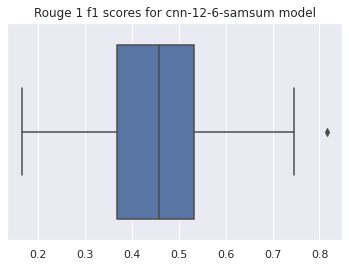

In [55]:
sns.set(style="darkgrid")
plt.title("Rouge 1 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_1_f1scores_finetuned_CNN)

In [56]:
print("Max for Rouge_2 f1 scores    : ", np.max(Rouge_2_f1scores_finetuned_CNN))
print("Min for Rouge_2 f1 scores    : ", np.min(Rouge_2_f1scores_finetuned_CNN))
print("Mean for Rouge_2 f1 scores   : ", np.mean(Rouge_2_f1scores_finetuned_CNN))
print("Median for Rouge_2 f1 scores : ", np.median(Rouge_2_f1scores_finetuned_CNN))

Max for Rouge_2 f1 scores    :  0.6111111061951303
Min for Rouge_2 f1 scores    :  0.0
Mean for Rouge_2 f1 scores   :  0.21075460668899765
Median for Rouge_2 f1 scores :  0.19512194672218927


<AxesSubplot:title={'center':'Rouge 2 f1 scores for cnn-12-6-samsum model'}>

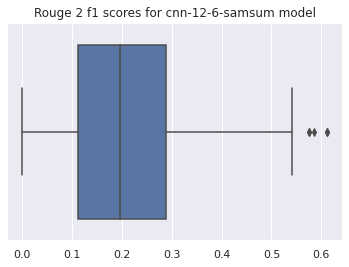

In [57]:
sns.set(style="darkgrid")
plt.title("Rouge 2 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_2_f1scores_finetuned_CNN)